# Anomaly Detection with GANs for Multivariate Time Series
https://arxiv.org/pdf/1809.04758.pdf

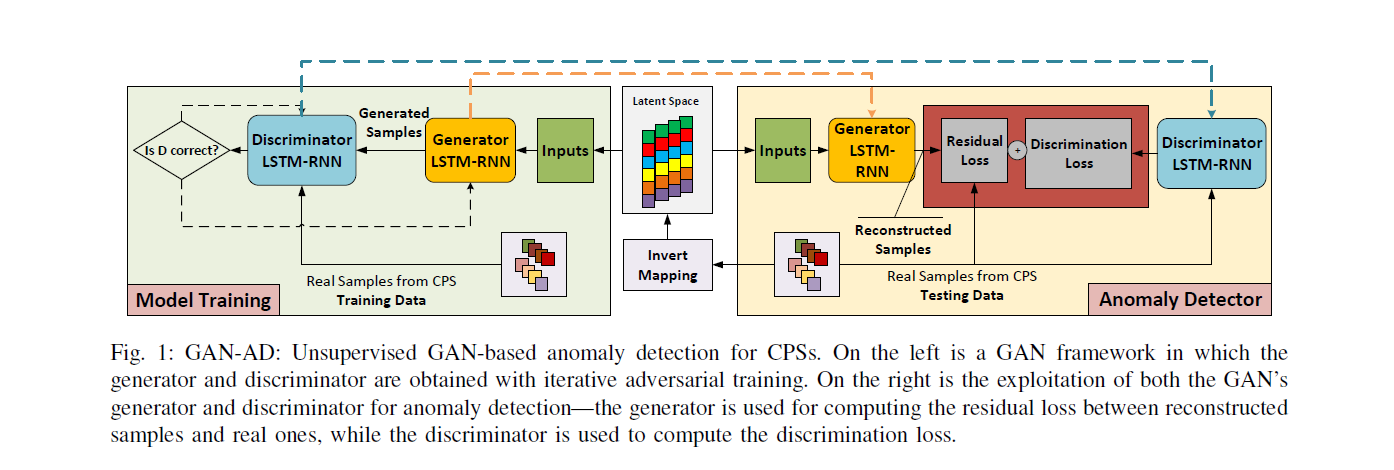

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from typing import Optional, Iterable

## Data loading

In [2]:
data = []
for root, dirs, files in os.walk("../datasets/skab/valve1/"):
    for file in files:
        if file.endswith(".csv"):
             data.append(os.path.join(root, file))

In [3]:
# single multivariate time series
df_data = pd.concat([pd.read_csv(time_series, index_col='datetime', sep=';',parse_dates=True) for time_series in data]).reset_index(drop=True) 

In [4]:
df_data

,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,0.026588,0.040111,1.330200,0.054711,79.3366,26.0199,233.062,32.0,0.0,0.0
1,0.026170,0.040453,1.353990,0.382638,79.5158,26.0258,236.040,32.0,0.0,0.0
2,0.026199,0.039419,1.540060,0.710565,79.3756,26.0265,251.380,32.0,0.0,0.0
3,0.026027,0.039641,1.334580,0.382638,79.6097,26.0393,234.392,32.0,0.0,0.0
4,0.026290,0.040273,1.078510,-0.273216,79.6109,26.0420,225.342,32.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
18157,0.028524,0.041076,0.622684,0.054711,67.6205,24.7763,233.878,32.0,0.0,0.0
18158,0.028092,0.041769,0.882653,0.054711,67.4618,24.7776,213.745,32.0,0.0,0.0
18159,0.027999,0.041164,0.569926,0.382638,67.6600,24.7834,224.067,32.0,0.0,0.0
18160,0.027862,0.041963,0.945311,-0.273216,67.6663,24.7752,235.491,32.0,0.0,0.0


## Data pre-processing

In [5]:
# remove the labels
df_data = df_data.drop(columns=['anomaly','changepoint'])

In [6]:
# split data to train and test, 75:25 ratio
ratio = 0.75
split = int(len(df_data)*ratio)

X_train_raw = df_data.iloc[:split,:].reset_index(drop=True) 
X_test_raw = df_data.iloc[split:,:].reset_index(drop=True) 

In [7]:
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

In [8]:
# PCA 
n_components = 5 # one of self. variables ? 
pca = PCA(n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [9]:
# def divide_time_series(time_series, window_size, shift):
#     divided = [time_series[i:i+window_size] for i in range(0,len(time_series)-window_size,shift)]
#     return np.stack(divided)

# X_train = divide_time_series(X_train_raw, window_size, train_shift)
# X_test = divide_time_series(X_test_raw, window_size, test_shift)

# print(X_train.shape)
# print(X_test.shape)

In [10]:
# values selected at random (for now)
window_size = 30 # one of self. variables ? 
train_shift = 5
test_shift = 30
batch_size = 20 # one of self. variables ? 

# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array
X_train = tf.keras.preprocessing.timeseries_dataset_from_array(X_train_pca.astype(np.float),
                                                               targets=None, sequence_length=window_size,
                                                               sequence_stride=train_shift, sampling_rate=1,
                                                               batch_size=batch_size, shuffle=True, seed=6)

X_test = tf.keras.preprocessing.timeseries_dataset_from_array(X_test_pca.astype(np.float),
                                                              targets=None, sequence_length=window_size,
                                                              sequence_stride=test_shift, sampling_rate=1,
                                                              batch_size=batch_size, shuffle=True, seed=6)

## Model architecture and loss functions

In [11]:
bce = BinaryCrossentropy()
def get_discriminator_loss(real, generated):
    real_loss = bce(tf.ones_like(real), real)
    generated_loss = bce(tf.zeros_like(generated), generated)
    d_loss = real_loss + generated_loss
    return d_loss

In [12]:
# "...the LSTM network for the discriminator is relatively simpler with 100 hidden units and depth 1..."
def build_discriminator():
    data = Input(shape=(window_size, n_components))

    x = LSTM(100)(data)
    decision = Dense(1, activation = 'sigmoid')(x)
    
    model = keras.Model(inputs=[data], outputs=[decision], name='discriminator')
    return model
# build_discriminator().summary()

In [13]:
def get_generator_loss(generated):
    return bce(tf.ones_like(generated), generated)

In [14]:
# "...we used an LSTM network with depth 3 and 100 hidden (internal) units for the generator..."
def build_generator():
    z = Input(shape=(latent_dim, 1))
    
    x = LSTM(20, return_sequences=True)(z)
    x = Dropout(0.2)(x) # TODO dropout layer?
    x = LSTM(60, return_sequences=True)(x)
    x = Dropout(0.2)(x) # TODO dropout layer?
    x = LSTM(20)(x)
    
    x = Dense((window_size*n_components), activation = 'tanh')(x)
    series = Reshape((window_size,n_components))(x)
    
    model = keras.Model(inputs=[z], outputs=[series], name='generator')
    return model
# build_generator().summary()

In [15]:
def build_gan(series_length, feature_columns, latent_dim): # future part of init?
    generator = build_generator()
    discriminator = build_discriminator()
    
    z = Input(shape=(latent_dim,))
    
    generated_series = generator([z])
    generated_series_eval = discriminator([generated_series])
    
    model = keras.Model(inputs=[z], outputs=[generated_series, generated_series_eval], name='gan')
    return model

In [16]:
@tf.function
def fit_batch(batch, z):
    with tf.GradientTape(persistent=True) as gt:
        discriminator = gan_ad.get_layer('discriminator')
        generator = gan_ad.get_layer('generator')
        
        generated_series = generator(z, training = True)
        generated_series_eval = discriminator(generated_series, training = True)
        real_series_eval = discriminator(batch, training = True)
        
        g_loss = get_generator_loss(generated_series_eval)
        d_loss = get_discriminator_loss(real_series_eval, generated_series_eval)

    discriminator_gradients = gt.gradient(d_loss, discriminator.trainable_variables)
    generator_gradients = gt.gradient(g_loss, generator.trainable_variables)
    
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    
    return (d_loss, g_loss)

In [10]:
def fit(dataset, epochs):
    loss_history = []
    for epoch in range(epochs):
        # TODO early stopping, HOW?
        batch_loss_history = []
        for batch in dataset:
            z = tf.random.normal([batch_size, latent_dim])
            d_loss, g_loss = fit_batch(batch, z)
            batch_loss_history.append([d_loss.numpy(), g_loss.numpy()])
        loss_history.append(np.mean(batch_loss_history, axis = 0))
        if ((epoch !=0) & (epoch%50 == 0)):
            print(epoch, ". epoch")
            print("Batch loss: ", np.mean(batch_loss_history, axis=0))
            plt.plot(np.array([loss[0] for loss in loss_history]), color='green')
            plt.plot(np.array([loss[1] for loss in loss_history]), color='blue')
#             plt.ylim(0, 2)
            plt.show()
            print()

One interpretation of the equation (5) is that  xi 's are the data points we already have and  yi 's are the generated examples so that MMD score guides us towards the evaluation of underlying distributions

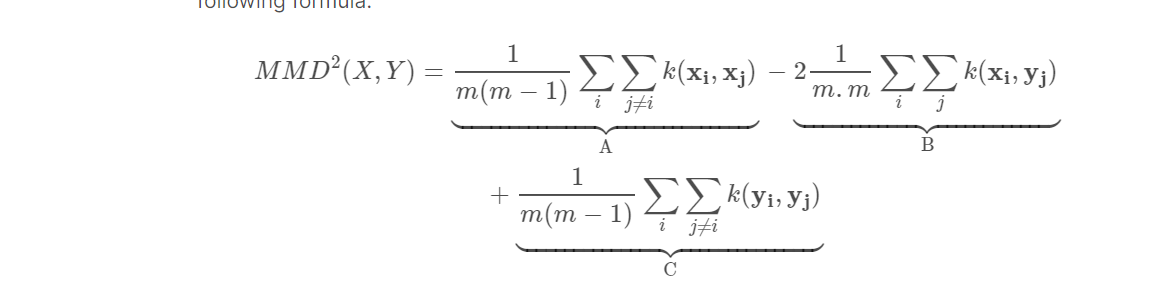

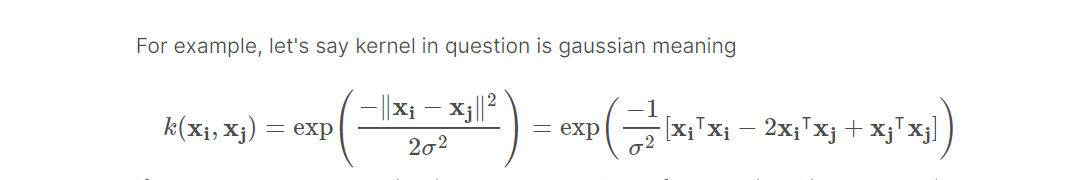

In [4]:
# https://www.kernel-operations.io/keops/_auto_tutorials/interpolation/plot_RBF_interpolation_numpy.html
# dtype = "float64"
# N = 100
# x = np.random.rand(N, 1).astype(dtype)
# b = (x+ 0.5 * np.sin(6 * x))

# def gaussian_kernel(x, y, sigma=0.1):
#     D = ((x - y) ** 2).sum(-1)  # (M, N) symbolic matrix of squared distances
#     return np.exp((-D / (2 * sigma ** 2)))  # (M, N) symbolic Gaussian kernel matrix

In [5]:
# K_xx = gaussian_kernel(x, x)
# K_xx = gaussian_kernel(x, b)
# K_xx

In [7]:
# https://github.com/ananda1996ai/MMD-AutoEncoding-GAN-MAEGAN-/blob/master/maegan_final.py
def rbf_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def get_mmd_similarity(x, y, sigma_sqr=1.0):
    x_kernel = rbf_kernel(x, x)
    y_kernel = rbf_kernel(y, y)
    xy_kernel = rbf_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [42]:
dtype = "float32"
# x = np.random.rand(30,4).astype(dtype)
b = (x).astype(dtype)
get_mmd_similarity(x, b)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [ ]:
def find_mapping(series, z):
    tolerance = 0.2
    reconstruction_loss = 1
    while(reconstruction_loss > tolerance):
        reconstruction_loss = 1 - get_mmd_similarity(series, z)
        

In [ ]:
def predict_anomaly_scores(dataset, epochs):
    for epoch in range(epochs):
        z_init = tf.random.normal([batch_size, latent_dim])
        for batch in dataset:
            z_mapping = find_mapping(batch, z_init)
            
#     # TODO calculate the residuals
#     # TODO calculate the discrimination results
#     # TODO obtain anomaly score

50 . epoch
Batch loss:  [1.079499 1.043499]


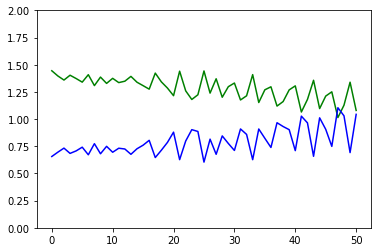


100 . epoch
Batch loss:  [1.1322855 1.0136524]


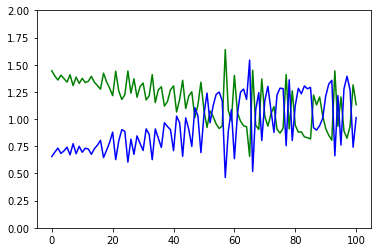


150 . epoch
Batch loss:  [0.75437313 1.4002762 ]


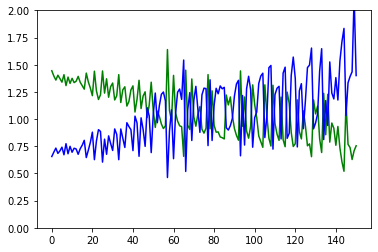


200 . epoch
Batch loss:  [0.5289117 3.013475 ]


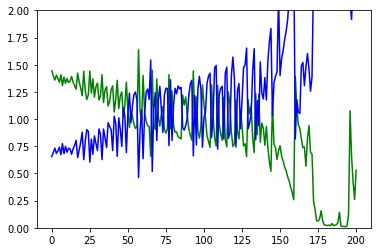


250 . epoch
Batch loss:  [0.40399098 2.2004907 ]


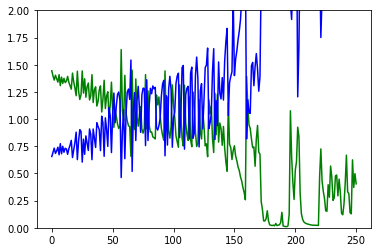


300 . epoch
Batch loss:  [0.11997741 2.8238246 ]


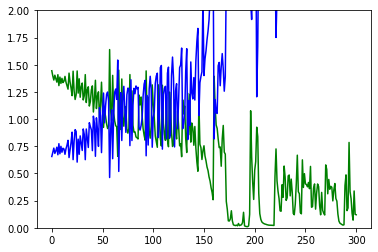


350 . epoch
Batch loss:  [0.49775684 1.9689354 ]


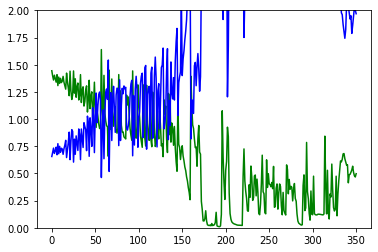


400 . epoch
Batch loss:  [0.38535494 2.032306  ]


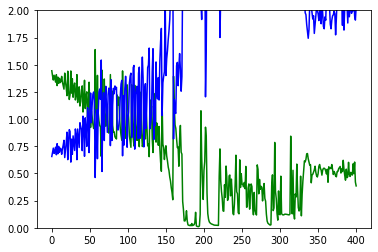


450 . epoch
Batch loss:  [0.3614121 1.9924673]


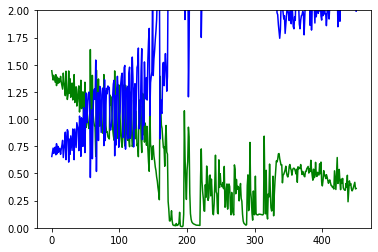


500 . epoch
Batch loss:  [0.35622668 2.0945103 ]


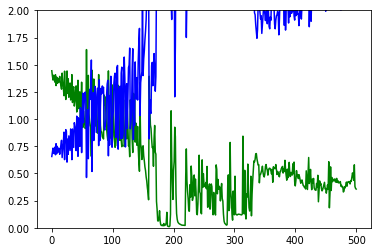


550 . epoch
Batch loss:  [0.28897786 2.6123064 ]


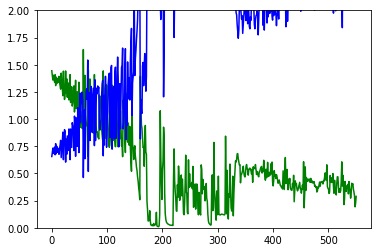


600 . epoch
Batch loss:  [0.44092992 2.615699  ]


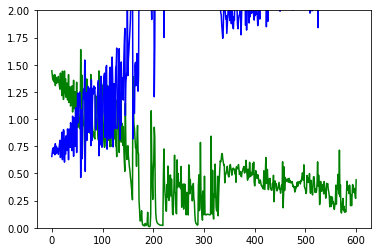


650 . epoch
Batch loss:  [0.19527283 2.6791954 ]


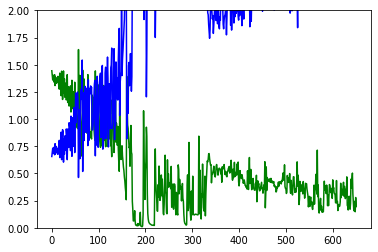


700 . epoch
Batch loss:  [0.28554276 2.6007273 ]


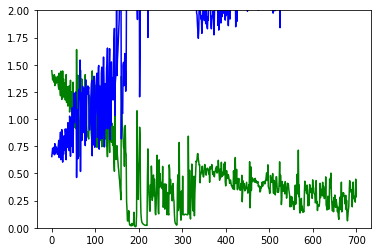


750 . epoch
Batch loss:  [0.22117272 2.8337233 ]


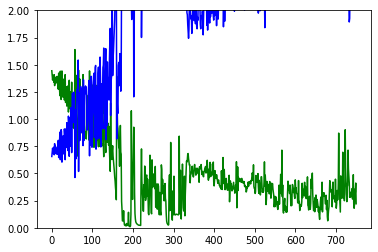


800 . epoch
Batch loss:  [0.40589568 2.8842716 ]


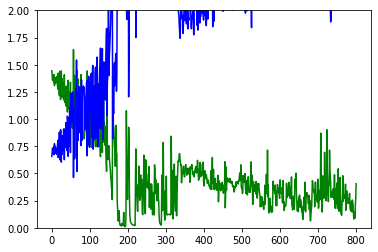


850 . epoch
Batch loss:  [0.01541475 4.293388  ]


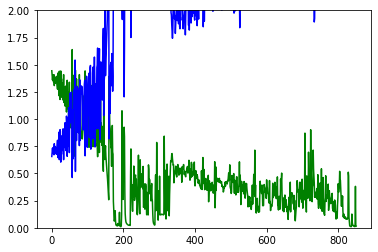


900 . epoch
Batch loss:  [0.01963724 4.0591803 ]


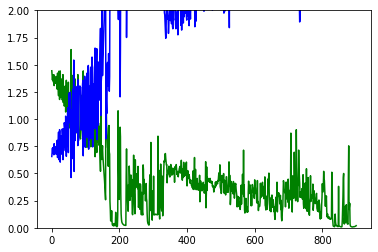


950 . epoch
Batch loss:  [0.00970593 4.6785626 ]


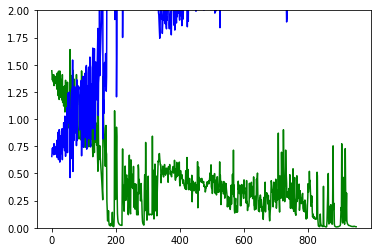

In [19]:
latent_dim = 4 # one of self. variables ? 
generator_optimizer = Adam(learning_rate=0.001)
discriminator_optimizer = SGD(learning_rate=0.001)
    
gan_ad = build_gan(window_size, n_components, latent_dim)
fit(X_train, 1000) 

Test iterations

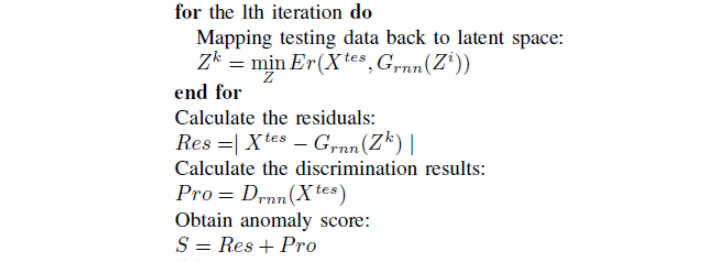

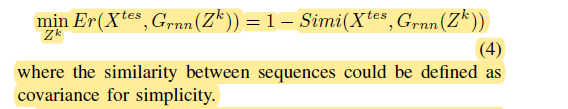

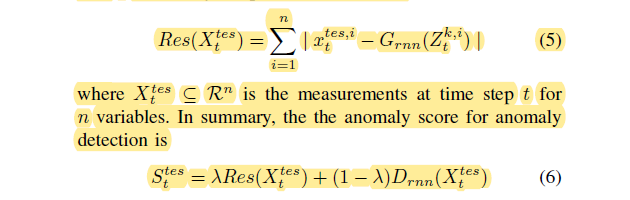

Anomaly detection - treshold

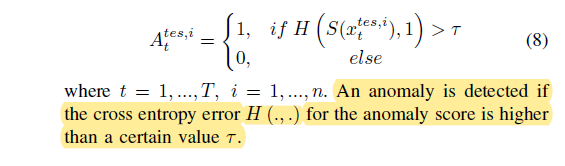

### Datamole's template, requirements :

The anomaly detector should be able to handle numerical data with missing values (nan values). In case the paper introducing the detector does not mention it and there is not a clear solution you can relax on it. For example in case the detector is working with certain window size, ignoring (window size - 1) samples after sample with a missing value is a possible solution (nan anomaly score should be returned for each ignored sample).

The anomaly detector must be able to handle multiple time series which are identified by the ID columns whose names are provided in the constructor argument `id_columns`. These columns should only be used to separate individual time series (not as feature columns). In case the paper introducing the detector does not mention training on multiple time series, try to come up with a reasonable solution. If there is not a clear reasonable solution you can relax on it.

In [ ]:
class GAN_AD(TimeSeriesAnomalyDetector):
    """
    Time series GAN anomaly detector.

    Parameters
    ----------
    id_columns: Iterable[str], optional
        ID columns used to identify individual time series.

        Should be specified in case the detector is provided with
        time series during training or inference with ID columns
        included. Using these columns the detector can separate individual
        time series and not use ID columns as feature columns.
        In case they are not specified, all columns are regarded as feature
        columns and the provided data is regarded as a single time series.
    """

    def __init__(
        self,
        id_columns: Optional[Iterable[str]] = None,
    ):
        super().__init__()
        self._id_columns = id_columns
        
    def predict_anomaly_scores(
            self, X: pd.DataFrame, *args, **kwargs
        ) -> pd.Series:
            """
            Predicts an anomaly score of the input samples. Samples should be
            ordered by their timestamps.

            An anomaly score is a measure of normality. The higher the score,
            the more abnormal the measured sample is.

            Parameters
            ----------
            X : pd.DataFrame, shape (n_samples, n_columns)
                The samples whose anomaly scores are to be predicted.
                The columns contain samples' features and possibly
                samples' identifiers.

            Returns
            -------
            scores : pd.Series, shape (n_samples,)
                The anomaly score of the input samples. The higher, the more
                abnormal.
            """
            # TODO: return predicted anomaly scores for the given samples

    def fit(self, X: pd.DataFrame, *args, **kwargs) -> None:
        """
        Fits the anomaly detector according to the given training data.

        Parameters
        ----------
        X : pd.DataFrame, shape (n_samples, n_columns)
            The training samples. The columns contain samples' features and
            possibly samples' identifiers.
        """
        # TODO: perform training